In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy.optimize import curve_fit

fs = 18
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'font.size': fs})
from matplotlib.ticker import EngFormatter
from matplotlib.dates import DateFormatter
import hydrofunctions as hf

In [2]:
# User-defined PATH TO DATA REPOSITORY
litrev_dir = '/Users/Dana/Desktop/Jupyter/WISC/NaturalCommunity/lit_review_data_supp/' 


In [3]:
pump_range = []
pump_rates = []
# for filename in os.listdir(litrev_dir +'pump_impacts'):
for filename in os.listdir(litrev_dir +'longterm_site_data_rev1'):
    
    try:
        pump_range = pump_range + [float(filename.split('_')[0])]
        pump_rates = pump_rates + [filename.split('_')[0]]
    except:
        print(filename[:-12])
        
air_temp = pd.read_csv(litrev_dir +'streamflow_data/temp_data_noaa.csv')[['DATE','TMAX']].set_index('DATE')
air_temp = air_temp.reset_index()
air_temp['DATE'] = pd.to_datetime(air_temp.DATE)
air_temp = air_temp.set_index('DATE')

In [4]:
# https://github.com/dadelforge/baseflow-separation/blob/master/physep/hysep.py
from scipy.ndimage.filters import minimum_filter1d, generic_filter

def fixed_interval_filter(ts, size):
    """USGS HYSEP fixed interval method
    
    The USGS HYSEP fixed interval method as described in `Sloto & Crouse, 1996`_.
    
    .. _Slot & Crouse, 1996:
        Sloto, Ronald A., and Michele Y. Crouse. “HYSEP: A Computer Program for Streamflow Hydrograph Separation and 
        Analysis.” USGS Numbered Series. Water-Resources Investigations Report. Geological Survey (U.S.), 1996. 
        http://pubs.er.usgs.gov/publication/wri964040.
    
    :param size: 
    :param ts: 
    :return: 
    """
    intervals = np.arange(len(ts)) // size
    baseflow = pd.Series(data=ts.groupby(intervals).transform('min'), index=ts.index)
    quickflow = ts - baseflow

    baseflow.name = 'baseflow'
    quickflow.name = 'quickflow'

    return baseflow, quickflow



In [5]:
# method to find break in slope and calculate trends on each side of break
# written by David Dralle

def func_broken_stick(x,threshold,b1,b2,a1):
    # a1, b1 are slope and intercept for left curve
    # b2 is slope for right curve
    # intercept on right curve is determined by the intersection constraint
    a2 = (b1*threshold - b2*threshold + a1)
    return np.where(x<threshold, b1*x+a1, b2*x+a2)

def broken_stick_fit(x, y, 
                    threshold_lower_percentile_bound=0,
                    threshold_upper_percentile_bound=100, 
                    slope_left_lower = -np.inf, 
                    slope_left_upper = np.inf,
                    slope_right_lower = -np.inf,
                    slope_right_upper = np.inf
                    ):
    """
    @desc:
    Fits broken stick, with constraints if desired. Note, if using for CQ power law fits, data should first
    be log-transformed.
    
    @params:
    threshold_upper_percentile: upper bound on possible thresholds determined through a percentile on the x data
    threshold_lower_percentile: lower bound on possible thresholds determined through a percentile on the x data
    slope_left_lower: lower constraint on left slope
    slope_left_upper: upper constraint on left slope
    slope_right_lower: lower constraint on right slope
    slope_right_upper: upper constraint on right slope
    
    @returns:
    popt: fitted broken stick paramters as a list
        [threshold: threshold for slope break, 
        b1: slope on left line, 
        b2: slope on right line,
        a1: intercept on left line]
        Note that if the curves intersect, the intercept on the right curve is constrained by the other fits
        a2 = (b1*threshold - b2*threshold + a1)
    standard_errors: standard errors for the fitted parameters
    """

    
    popt_temp, pcov_temp = curve_fit(func_broken_stick, x, y, 
                                    bounds = [(np.percentile(x,threshold_lower_percentile_bound), slope_left_lower, slope_right_lower, -np.inf), 
                                              (np.percentile(x,threshold_upper_percentile_bound), slope_left_upper, slope_right_upper, np.inf)
                                             ]
                                   )
    standard_errors = np.sqrt(np.diag(pcov_temp))
    return popt_temp, standard_errors

In [84]:
def calc_season_dates(temp):
    spring_check = temp[~(temp.isna())].loc[pd.to_datetime('1-1-1999'):pd.to_datetime('4-1-1999')]
    spring_check = spring_check[np.isfinite(spring_check)]
    popt_spring, error = broken_stick_fit(list(range(len(spring_check))),
                    spring_check)
    [threshold, b1, b2, a1] = popt_spring
    spring_start_date = (spring_check.index.values[int(round(threshold))])
    summer_check = temp[~(temp.isna())].loc[pd.to_datetime('5-1-1999'):pd.to_datetime('8-1-1999')]
    summer_check = summer_check[np.isfinite(summer_check)]
    popt_summer, error = broken_stick_fit(list(range(len(summer_check))),
                    summer_check)
    [threshold, b1, b2, a1] = popt_summer
    summer_start_date = (summer_check.index.values[int(round(threshold))])
    fall_check = temp[~(temp.isna())].loc[pd.to_datetime('7-1-1999'):pd.to_datetime('11-15-1999')]
    fall_check = fall_check[np.isfinite(fall_check)]
    popt_fall, error = broken_stick_fit(list(range(len(fall_check))),
                    fall_check)
    [threshold, b1, b2, a1] = popt_fall
    fall_start_date = (fall_check.index.values[int(round(threshold))])
    winter_check = temp[~(temp.isna())].loc[pd.to_datetime('10-1-1999'):pd.to_datetime('12-31-1999')]
    winter_check = winter_check[np.isfinite(winter_check)]
    popt_winter, error = broken_stick_fit(list(range(len(winter_check))),
                    winter_check)
    [threshold, b1, b2, a1] = popt_winter
    winter_start_date = (winter_check.index.values[int(round(threshold))])
    return([spring_start_date,summer_start_date,fall_start_date,winter_start_date])

def winter_metrics(df,seasons):
    df = df.reset_index()
    df['datetime'] = df.datetimeUTC
    df = df.set_index(df.datetimeUTC)
    winterdf = df[df.datetime.dt.month>seasons[3].month].set_index('datetime')
    winterdf1 = df[df.datetime.dt.month<seasons[0].month].set_index('datetime')
    winterdf2 = df[(df.datetime.dt.month==seasons[0].month) &
                                (df.datetime.dt.day<seasons[0].day)].set_index('datetime')
    winterdf3 = df[(df.datetime.dt.month==seasons[3].month) &
                                (df.datetime.dt.day>=seasons[3].day)].set_index('datetime')
    temp = pd.concat([winterdf,winterdf1,winterdf2,winterdf3])
    try:
        mean_daily = np.nanmean(temp.guess_temp)
    except:
        mean_daily = np.nanmean(temp.impact_temp)
    min_daily = []
#     max_daily = []
    min_date = []
    T5_date = []
    T75_date = []
#     print(temp)
    years = temp.datetimeUTC.dt.year.drop_duplicates().values
    num_years = len(years)
    DD2_5 = []
    freq_below2 = []
    freq_below0 = []
    for yr in years:
        try:
            t = temp[temp.datetimeUTC.dt.year==yr][['guess_temp']]
        except:
            t = temp[temp.datetimeUTC.dt.year==yr][['impact_temp']]
        T5_date = T5_date +[pd.to_datetime(t[t==np.nanpercentile(t,5)].index.values[0])]
        T75_date = T75_date + [pd.to_datetime(t[t==np.nanpercentile(t,75)].index.values[0])]
        DD25 = np.array(t.values)-np.array([2.5]*len(t))
        DD25 = np.nansum(np.where(DD25<0,abs(np.array(DD25)),0))
        DD2_5 = DD2_5 + [DD25]
        num2 = 0
        below = False
        for i in range(len(t)):
            if t.values[i]<2 and below==False:
                num2 +=1
                below = True
            if t.values[i]>2 and below==True:
                below = False
        freq_below2 = freq_below2 + [num2]
        num0 = 0
        below = False
        for i in range(len(t)):
            if t.values[i]<0 and below==False:
                num0 +=1
                below = True
            elif t.values[i]>0 and below==True:
                below = False
        freq_below0 = freq_below0 + [num0]
        min_daily = min_daily + [np.nanmin(t)]
        min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
    min_daily = np.nanmean(min_daily)
    min_date = ["%02d%02d" %(min_date[i].month,min_date[i].day) for i in range(len(min_date))]
    min_date = sorted(min_date)[len(min_date)//2]
    min_date = pd.to_datetime(min_date[:2]+'-'+min_date[2:]+'-1999')
    T5_date = ["%02d-%02d"%(T5_date[i].month, T5_date[i].day) for i in range(len(T5_date))]
    T5_date = sorted(T5_date)[len(T5_date)//2]
    T5_date = pd.to_datetime(T5_date[:2]+'-'+T5_date[2:]+'-1999')
    T75_date = ["%02d-%02d" % (T75_date[i].month,T75_date[i].day) for i in range(len(T75_date))]
    T75_date = sorted(T75_date)[len(T75_date)//2]
    T75_date = pd.to_datetime(T75_date[:2]+T75_date[2:]+'-1999')
    freq_below2 = np.nanmean(freq_below2)
    freq_below0 = np.nanmean(freq_below0)
    try:
        below2 = len(temp[temp.guess_temp<=2])/num_years
        above4_5 = len(temp[temp.guess_temp>=4.5])/num_years
        cv = np.nanstd(temp.guess_temp)/np.nanmean(temp.guess_temp)
    except:
        below2 = len(temp[temp.impact_temp<=2])/num_years
        above4_5 = len(temp[temp.impact_temp>=4.5])/num_years
        cv = np.nanstd(temp.impact_temp)/np.nanmean(temp.impact_temp)
    DD2_5 = np.nanmean(DD2_5)
    return({'mean_daily':mean_daily,'T5_date':T5_date, 'T75_date':T75_date,
            'CV':cv, 'DD2.5':DD2_5, 'min_date':min_date, 'min_daily':min_daily,
           'below2':below2, 'freq_below2':freq_below2, 'freq_freeze':freq_below0,
           'above4.5':above4_5})

def spring_metrics(df,seasons):
#     print(df)
    springdf = df.reset_index()[(df.reset_index().datetimeUTC.dt.month>seasons[0].month) &
                               (df.reset_index().datetimeUTC.dt.month<seasons[1].month)].set_index('datetimeUTC')
    springdf2 = df.reset_index()[(df.reset_index().datetimeUTC.dt.month==seasons[0].month) &
                                (df.reset_index().datetimeUTC.dt.day>=seasons[0].day)].set_index('datetimeUTC')
    springdf3 = df.reset_index()[(df.reset_index().datetimeUTC.dt.month==seasons[1].month) &
                                (df.reset_index().datetimeUTC.dt.day<seasons[1].day)].set_index('datetimeUTC')
    temp = pd.concat([springdf,springdf2,springdf3])
    mean_daily = np.nanmean(temp)
    min_daily = []
    max_daily = []
    min_date = []
    years = temp.reset_index().datetimeUTC.dt.year.drop_duplicates().values
    num_years = len(years)
    for yr in years:
        t = temp.reset_index()[temp.reset_index().datetimeUTC.dt.year==yr].set_index('datetimeUTC')
        min_daily = min_daily + [np.nanmin(t)]
        max_daily = max_daily + [np.nanmax(t)]
    max_daily = np.nanmean(max_daily)
    cv = np.nanstd(temp)/np.nanmean(temp)
    return({'mean_daily':mean_daily,'CV':cv})

def summer_metrics(df,seasons):
    summerdf = df.reset_index()[(df.reset_index().datetimeUTC.dt.month>seasons[1].month) &
                               (df.reset_index().datetimeUTC.dt.month<seasons[2].month)].set_index('datetimeUTC')
    summerdf2 = df.reset_index()[(df.reset_index().datetimeUTC.dt.month==seasons[1].month) &
                                (df.reset_index().datetimeUTC.dt.day>=seasons[1].day)].set_index('datetimeUTC')
    summerdf3 = df.reset_index()[(df.reset_index().datetimeUTC.dt.month==seasons[2].month) &
                                (df.reset_index().datetimeUTC.dt.day<seasons[2].day)].set_index('datetimeUTC')
    temp = pd.concat([summerdf,summerdf2,summerdf3])
    mean_daily = np.nanmean(temp)
    max_daily = []
    max_date = []
    years = temp.reset_index().datetimeUTC.dt.year.drop_duplicates().values
    num_years = len(years)
    event_above25 = []
    DD25 = []
    median_daily_roc = []
    for yr in years:
        t = temp.reset_index()[temp.reset_index().datetimeUTC.dt.year==yr].set_index('datetimeUTC')
        max_daily = max_daily + [np.nanmax(t)]
        max_date = t[t==np.nanmax(t)].index.values[0]
        above25 = 0
        hot = False
        for i in range(len(t)):
            if t.values[i]>25 and hot==False:
                hot = True
                above25+=1
            elif t.values[i]<25 and hot==True:
                hot = False
        event_above25 = event_above25 + [above25]
        DD25_annual = np.array(t.values)-np.array([25]*len(t))
        DD25_annual = np.where(DD25_annual<0,0,DD25_annual)
        DD25 = DD25 + [np.nansum(DD25_annual)]
        daily_roc = np.array(t.values)[1:]-np.array(t.values[:-1])
        median_daily_roc = median_daily_roc + [np.nanmedian(daily_roc)]
    max_daily = np.nanmean(max_daily)
    max_date = (np.array(max_date, dtype='datetime64[s]')
        .view('i8')
        .mean()
        .astype('datetime64[s]'))
    mean_5day = temp.resample('5D').max()
    mean_5day = np.nanmean(mean_5day)
    event_above25 = np.nanmean(event_above25)
    above25 = len(temp[temp>=22])/num_years
    cv = np.nanstd(temp)/np.nanmean(temp)
    weekly_range = temp.resample('7D').max()-temp.resample('7D').min()
    weekly_range = np.nanmean(weekly_range)
    DD25 = np.nanmean(DD25)
    median_daily_roc = np.nanmean(median_daily_roc)
    return({'mean_daily':mean_daily,'max_daily':max_daily,
            'max_date':max_date,'events>25':event_above25, 'DD25':DD25,
            'weekly_range':weekly_range,'median_daily_roc':median_daily_roc,
            'mean_5day':mean_5day,
                     'CV':cv})

def fall_metrics(df,seasons):
    falldf = df.reset_index()[(df.reset_index().datetimeUTC.dt.month>seasons[2].month) &
                               (df.reset_index().datetimeUTC.dt.month<seasons[3].month)].set_index('datetimeUTC')
    falldf2 = df.reset_index()[(df.reset_index().datetimeUTC.dt.month==seasons[2].month) &
                                (df.reset_index().datetimeUTC.dt.day>=seasons[2].day)].set_index('datetimeUTC')
    falldf3 = df.reset_index()[(df.reset_index().datetimeUTC.dt.month==seasons[3].month) &
                                (df.reset_index().datetimeUTC.dt.day<seasons[3].day)].set_index('datetimeUTC')
    temp = pd.concat([falldf,falldf2,falldf3])
    mean_daily = np.nanmean(temp)
    max_daily = []
    years = temp.reset_index().datetimeUTC.dt.year.drop_duplicates().values
    num_years = len(years)
    roc = []
    for yr in years:
        t = temp.reset_index()[temp.reset_index().datetimeUTC.dt.year==yr].set_index('datetimeUTC')
        max_daily = max_daily + [np.nanmax(t)]
        roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
    max_daily = np.nanmean(max_daily)
    cv = np.nanstd(temp)/np.nanmean(temp)
    roc = np.nanmean(roc)
    return({'mean_daily':mean_daily,'roc':roc})


def calc_diff(metric,metric_impact,season):
    diff = {}
    for key in metric.keys():
        
        if key in ['min_date','max_date','T5_date','T75_date',]:
            diff[season+'_'+key] = (pd.to_datetime(metric_impact[key])-pd.to_datetime(metric[key]))
        elif key in ['mean_daily','max_daily','min_daily','mean_5day']:
            if (metric[key])==0:
                diff[season+'_'+key] = (np.nan)
            else:
                diff[season+'_'+key] = metric_impact[key]-metric[key]
        elif key in ['roc','CV','median_daily_roc','weekly_range','event_above25','DD25','DD2.5',
                    'below2','freq_below2','freq_freeze','above4.5']:
            if (metric[key])==0:
                diff[season+'_'+key] = (np.nan)
            else:
                diff[season+'_'+key] = (metric_impact[key]-metric[key])/metric[key]*100
    return(diff)

def calc_metrics(df):
    # first, annualize this thing
    df = df.reset_index()
    df['datetime'] = df.datetimeUTC
    df = df.set_index(df.datetimeUTC)
    df_1yr = df#.reset_index()
    df_1yr = df_1yr[(df_1yr.datetime.dt.day!=29) | (df_1yr.datetime.dt.month!=2)]
    df_1yr['datetime'] = np.where(df_1yr.datetime.dt.month>=1,
                                 df_1yr['datetime'].apply(lambda x: x.replace(year = 1999)),
                                 df_1yr['datetime'].apply(lambda x: x.replace(year = 1999)))
    df_1yr = df_1yr.sort_index()
    df_1yr = df_1yr.set_index('datetime')
    seasons = calc_season_dates(df_1yr.guess_temp.resample('D').mean())
    seasons_impact = calc_season_dates(df_1yr.impact_temp.resample('D').mean())
    seasons = [pd.to_datetime(seasons[i]) for i in range(len(seasons))]
    seasons_impact = [pd.to_datetime(seasons_impact[i]) for i in range(len(seasons_impact))]
    
    
    winter = winter_metrics(df.guess_temp,seasons)
    winter_impact = winter_metrics(df.impact_temp,seasons_impact)
#     print(winter)
#     print(winter_impact)
    winter_diff = calc_diff(winter,winter_impact,'winter')
    
    spring = spring_metrics(df.guess_temp,seasons)
    spring_impact = spring_metrics(df.impact_temp,seasons_impact)
    spring_diff = calc_diff(spring,spring_impact,'spring')
    
    summer = summer_metrics(df.guess_temp,seasons)
    summer_impact = summer_metrics(df.impact_temp,seasons_impact)
    summer_diff = calc_diff(summer,summer_impact,'summer')

    
    fall = fall_metrics(df.guess_temp,seasons)
    fall_impact = fall_metrics(df.impact_temp,seasons_impact)
    fall_diff = calc_diff(fall,fall_impact,'fall')
    
    metric_diff = winter_diff
    metric_diff.update(spring_diff)
    metric_diff.update(summer_diff)
    metric_diff.update(fall_diff)
    return(metric_diff)


In [13]:
keepsites = pd.read_csv('sites_for_analysis.csv')
keepsites['sitenum'] = keepsites.sitenum.astype('str')

In [89]:
baseflow_temp = 9.9 # set to 9.9 deg Celsius, which is the median mean annual streamflow temp. across all sites with temp. data
window_size = 5000 # window size for baseflow separation (hours)


def remove_timezone(dt):
   
    # HERE `dt` is a python datetime
    # object that used .replace() method
    return dt.replace(tzinfo=None)

metric_impact = {}

# USGS_ref = os.listdir(litrev_dir+'streamflow_data')
# USGS_ref = [f for f in USGS_ref if f!='temp_data_noaa.csv']
USGS_ref = keepsites.sitenum.values

for i in range(len(USGS_ref)):
    site = USGS_ref[i]
    print(i,site)
    site_num ='0'+site
#     flow_data = pd.read_csv(litrev_dir+'streamflow_data/'+site_num)
#     flow_data = flow_data.reset_index()
#     flow_data['datetime'] = pd.to_datetime(flow_data.datetime)
#     flow_data['discharge_cmd'] = flow_data.Q_m3d
#     flow_data = flow_data.set_index('datetime')
    flow_data = hf.NWIS(site_num,'dv',start_date='1980-1-1',end_date='2021-10-1',
       parameterCd='00060').df()
    flow_data = flow_data[~(flow_data[flow_data.columns[1]]=='hf.missing')]
    flow_data = flow_data[[flow_data.columns[0]]].rename(columns={flow_data.columns[0]:'Q_cfs'})
    flow_data['Q_m3d'] = flow_data.Q_cfs*12**3*2.54**3/100**3*3600*24
    flow_data['Q_m3d'] = flow_data.Q_m3d/np.nanmedian(flow_data.Q_m3d)
    flow_data['discharge_cmd'] = flow_data.Q_m3d
    flow_data = flow_data.reset_index()
    flow_data['datetimeUTC'] = flow_data.datetimeUTC.apply(remove_timezone)
    flow_data['datetime'] = flow_data['datetimeUTC']
    flow_data = flow_data.set_index('datetimeUTC')
    flow_data['air_temp'] = flow_data.merge(air_temp,left_index=True,right_index=True,how='left').TMAX.ffill()


    baseflow,quickflow = fixed_interval_filter(flow_data.discharge_cmd,window_size)
    flow_data['baseflow'] = baseflow
    flow_data['quickflow'] = quickflow
    flow_data['guess_temp'] = (flow_data.baseflow*baseflow_temp+flow_data.quickflow.mul(flow_data.air_temp,axis=0))
    flow_data['guess_temp'] = flow_data.guess_temp.mul(1/flow_data.discharge_cmd,axis=0)


    # pick pump rate as 1.25 times baseflow median
    pump_rate = np.nanmedian(flow_data.baseflow)*1.25
    print(pump_rate)
    pumprate_diff = abs(pump_range-pump_rate)
    pump_rate = pump_rates[list(pumprate_diff).index(min(pumprate_diff))]

    impacts = pd.read_csv(litrev_dir+'longterm_site_data_rev1/'+str(pump_rate)+'_impacts.csv').drop(columns=['Unnamed: 0','times'])
    flow_data = (flow_data.reset_index().merge(impacts,left_index=True,right_index=True)).set_index('datetimeUTC')
    flow_data['discharge_impact'] = flow_data.discharge_cmd-flow_data.Qs
    baseflow_impact,quickflow_impact = fixed_interval_filter(flow_data.discharge_impact,window_size)
    flow_data['baseflow_impact'] = baseflow_impact
    flow_data['quickflow_impact'] = quickflow_impact
    flow_data['impact_temp'] = (flow_data.baseflow_impact*baseflow_temp+flow_data.quickflow_impact.mul(flow_data.air_temp,axis=0))
    flow_data['impact_temp'] = flow_data.impact_temp.mul(1/flow_data.discharge_impact,axis=0)

    flow_data = flow_data.sort_index()
    impacts = calc_metrics(flow_data)

    if metric_impact=={}:
        for key in impacts:
            metric_impact[key] = [impacts[key]]
    else:
        for key in metric_impact:
            metric_impact[key] = metric_impact[key]+[impacts[key]]


0 40263205
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=040263205&parameterCd=00060&startDT=1980-1-1&endDT=2021-10-1
1.0438829787234043


<ipython-input-84-29b7bd0a21d0>:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1yr['datetime'] = np.where(df_1yr.datetime.dt.month>=1,


1 4073462
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=04073462&parameterCd=00060&startDT=1980-1-1&endDT=2021-10-1
0.029239766081871343


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-84-29b7bd0a21d0>:82: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-84-29b7bd0a21d0>:83: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
<ipython-input-84-29b7bd0a21d0>:127: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-84-29b7bd0a21d0>:128: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-84-29b7bd0a21d0>:151: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-84-29b7bd0a21d0>:152: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: Runt

2 4073468
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=04073468&parameterCd=00060&startDT=1980-1-1&endDT=2021-10-1
-0.375


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
<ipython-input-84-29b7bd0a21d0>:226: RuntimeWarning: invalid value encountered in double_scalars
  diff[season+'_'+key] = (metric_impact[key]-metric[key])/metric[key]*100


3 40857005
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=040857005&parameterCd=00060&startDT=1980-1-1&endDT=2021-10-1
0.40625
4 40869416
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=040869416&parameterCd=00060&startDT=1980-1-1&endDT=2021-10-1
0.07183908045977012
5 4087030
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=04087030&parameterCd=00060&startDT=1980-1-1&endDT=2021-10-1
0.0578125
6 4087070
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=04087070&parameterCd=00060&startDT=1980-1-1&endDT=2021-10-1
0.0
7 4087088
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=04087088&parameterCd=00060&startDT=1980-1-1&endDT=2021-10-1
0.26315789473684215
8 4087119
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=04087119&parameterCd=00060&startDT=1980-1-1&endDT=2021-10-1
0.35326086

/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


9 40871473
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=040871473&parameterCd=00060&startDT=1980-1-1&endDT=2021-10-1
0.0
10 40871475
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=040871475&parameterCd=00060&startDT=1980-1-1&endDT=2021-10-1
0.0
11 40871488
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=040871488&parameterCd=00060&startDT=1980-1-1&endDT=2021-10-1
0.1275510204081633
12 4087159
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=04087159&parameterCd=00060&startDT=1980-1-1&endDT=2021-10-1
0.3267045454545453
13 4087204
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=04087204&parameterCd=00060&startDT=1980-1-1&endDT=2021-10-1
0.05500000000000001
14 4087214
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=04087214&parameterCd=00060&startDT=1980-1-1&endDT=2021-10-1

In [90]:
# summary of results for all sites

print('metric','median','25th percentile','75th percentile')
for metric in metric_impact.keys():
    try:
        print(metric,
              np.nanmedian(metric_impact[metric]),
              np.nanpercentile(metric_impact[metric],25),
              np.nanpercentile(metric_impact[metric],75))
    except:
        days = [metric_impact[metric][i].days for i in range(len(metric_impact[metric]))]
        print(metric,np.nanmedian(days),np.nanpercentile(days,25),np.nanpercentile(days,75))

metric median 25th percentile 75th percentile
winter_mean_daily -0.18975033053460694 -0.4496625102852383 -0.019720900091445143
winter_T5_date 0.0 0.0 0.0
winter_T75_date 0.0 0.0 0.0
winter_CV -0.0017981857331558443 -69.58694281579926 29.587665178351862
winter_DD2.5 5.385485417680671 0.6328567826708643 19.025619105695796
winter_min_date 0.0 0.0 0.0
winter_min_daily -0.47655485600662484 -1.01350164262566 -0.0754712622411362
winter_below2 1.9102196752626546 0.0 6.455399061032864
winter_freq_below2 0.0 -1.4778325123152656 1.357466063348415
winter_freq_freeze 0.7812500000000098 -0.41841004184100267 7.77777777777777
winter_above4.5 -1.7161568879801603 -12.869896101373985 0.0
spring_mean_daily 0.012852593839326687 -0.008274236240240374 0.10075376864659136
spring_CV 2.322705501227832 0.24396814549039114 6.265212801483165
summer_mean_daily 0.31814659740753903 0.061933713414782154 0.8018513518802122
summer_max_daily 0.3760718621010639 0.07848486314508385 0.6012677051262383
summer_max_date 0.0 0.

In [109]:
df = pd.DataFrame.from_dict(metric_impact)
df.winter_freq_freeze.median()

0.7812500000000098

In [94]:
temp_impacts = pd.DataFrame.from_dict(metric_impact)
temp_impacts['site'] = USGS_ref
# temp_impacts

In [100]:
%matplotlib inline
plt.rcParams.update({'font.size': fs})

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=05370000&parameterCd=00060&startDT=1980-1-1&endDT=2021-10-1


<ipython-input-84-29b7bd0a21d0>:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1yr['datetime'] = np.where(df_1yr.datetime.dt.month>=1,
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-84-29b7bd0a21d0>:82: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-84-29b7bd0a21d0>:83: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
<ipython-input-84-29b7bd0a21d0>:127: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-84-29b7bd0a21d0>:128: RuntimeWarning: All-NaN axis

Text(1999-02-16 00:00:00, 36, '')

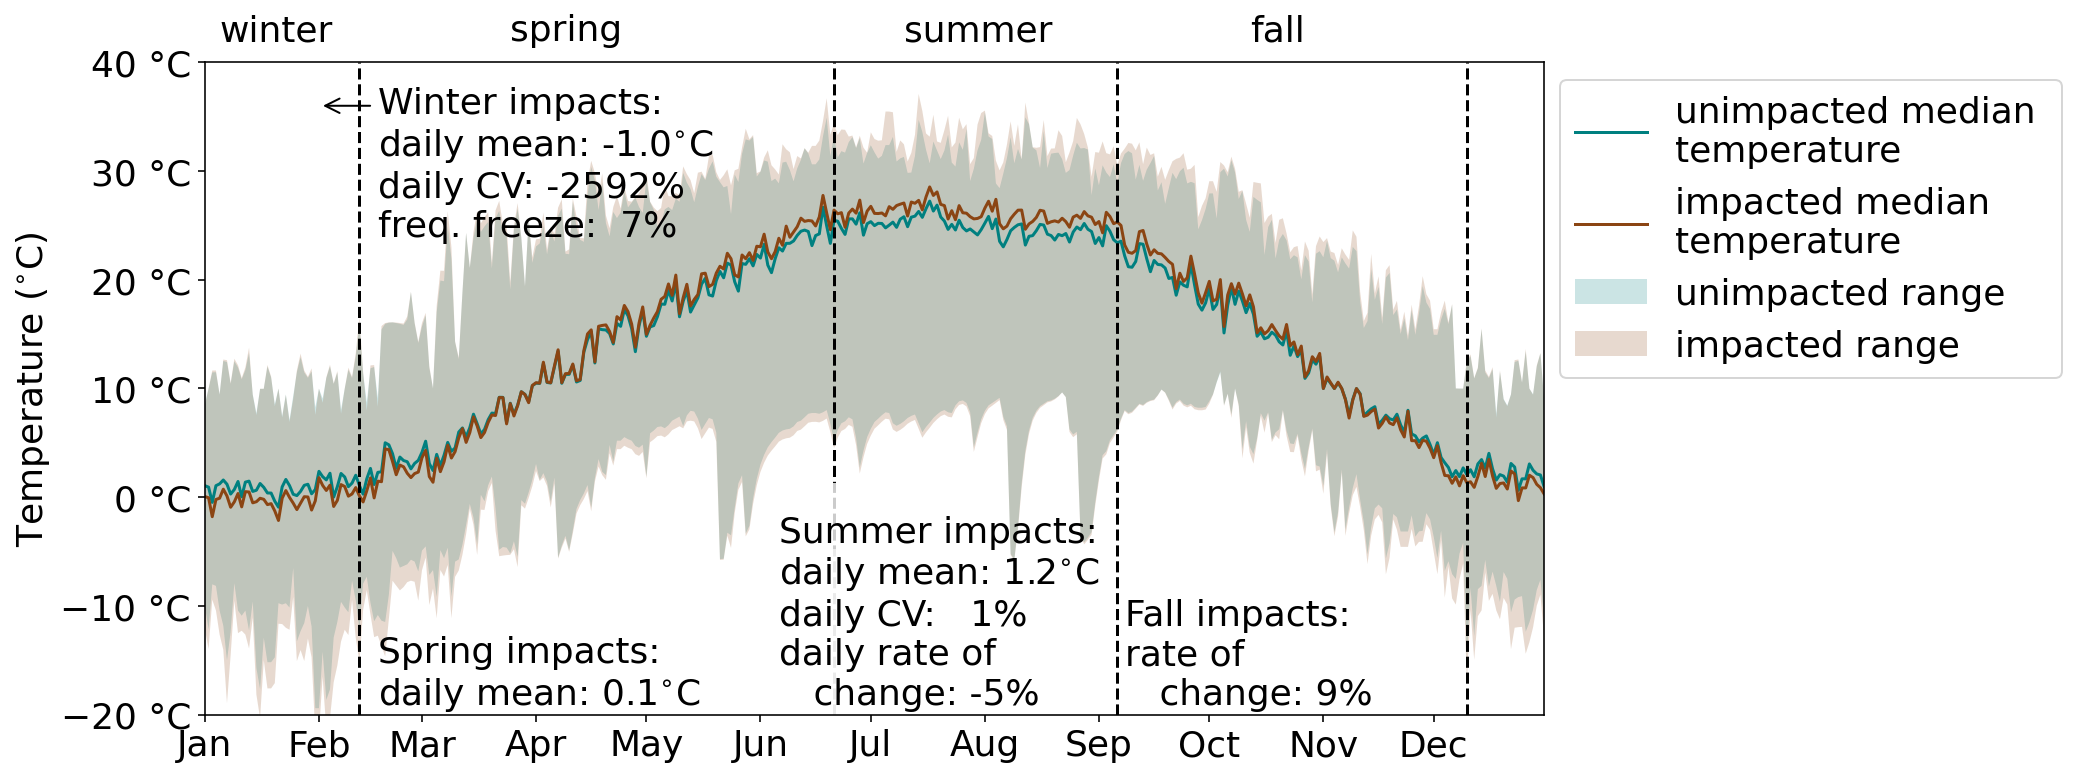

In [104]:
# plot example impacts for one site

site_num = '05370000'
window_size = 5000

sitestats = temp_impacts[temp_impacts.site==site_num]

flow_data = hf.NWIS(site_num,'dv',start_date='1980-1-1',end_date='2021-10-1',
       parameterCd='00060').df()
flow_data = flow_data[~(flow_data[flow_data.columns[1]]=='hf.missing')]
flow_data = flow_data[[flow_data.columns[0]]].rename(columns={flow_data.columns[0]:'Q_cfs'})
flow_data['Q_m3d'] = flow_data.Q_cfs*12**3*2.54**3/100**3*3600*24
flow_data['Q_m3d'] = flow_data.Q_m3d/np.nanmedian(flow_data.Q_m3d)
flow_data['discharge_cmd'] = flow_data.Q_m3d
flow_data = flow_data.reset_index()
flow_data['datetimeUTC'] = flow_data.datetimeUTC.apply(remove_timezone)
flow_data['datetime'] = flow_data['datetimeUTC']
flow_data = flow_data.set_index('datetimeUTC')
flow_data['air_temp'] = flow_data.merge(air_temp,left_index=True,right_index=True,how='left').TMAX.ffill()


# flow_data = pd.read_csv(litrev_dir+'streamflow_data/'+site_num+'.csv')
# flow_data = flow_data.reset_index()
# flow_data['datetime'] = pd.to_datetime(flow_data.datetime)
# flow_data = flow_data.set_index('datetime')
# flow_data['discharge_cmd'] = flow_data.Q_m3d
# flow_data['air_temp'] = flow_data.merge(air_temp,left_index=True,right_index=True,how='left').TMAX.ffill()


baseflow,quickflow = fixed_interval_filter(flow_data.discharge_cmd,window_size)
flow_data['baseflow'] = baseflow
flow_data['quickflow'] = quickflow
flow_data['guess_temp'] = (flow_data.baseflow*baseflow_temp+flow_data.quickflow.mul(flow_data.air_temp,axis=0))
flow_data['guess_temp'] = flow_data.guess_temp.mul(1/flow_data.discharge_cmd,axis=0)

# pick pump rate as 1.25 times baseflow median
pump_rate = np.nanmedian(flow_data.baseflow)*1.25
pumprate_diff = abs(pump_range-pump_rate)
pump_rate = pump_rates[list(pumprate_diff).index(min(pumprate_diff))]

impacts = pd.read_csv(litrev_dir+'longterm_site_data_rev1/'+str(pump_rate)+'_impacts.csv').drop(columns=['Unnamed: 0','times'])
flow_data = (flow_data.reset_index().merge(impacts,left_index=True,right_index=True)).set_index('datetime')
flow_data['discharge_impact'] = flow_data.discharge_cmd-flow_data.Qs
baseflow_impact,quickflow_impact = fixed_interval_filter(flow_data.discharge_impact,window_size)
flow_data['baseflow_impact'] = baseflow_impact
flow_data['quickflow_impact'] = quickflow_impact
flow_data['impact_temp'] = (flow_data.baseflow_impact*baseflow_temp+flow_data.quickflow_impact.mul(flow_data.air_temp,axis=0))
flow_data['impact_temp'] = flow_data.impact_temp.mul(1/flow_data.discharge_impact,axis=0)

flow_data = flow_data.sort_index()
impacts = calc_metrics(flow_data)
flow_data = flow_data.reset_index()[(flow_data.reset_index().datetime.dt.month!=2)|(flow_data.reset_index().datetime.dt.day!=29)].set_index('datetime')

flow_data['date'] = np.where(flow_data.reset_index().datetime.dt.month>=1,
                             flow_data.reset_index()['datetime'].apply(lambda x: x.replace(year = 1999)),
                             flow_data.reset_index()['datetime'].apply(lambda x: x.replace(year = 1999)))
flow_data1 = flow_data.set_index('date').sort_index()

seasons = calc_season_dates(flow_data1.guess_temp.resample('D').mean())



impactcolor = 'saddlebrown'
basecolor = 'teal'

# plot example impacts
fig,ax = plt.subplots(1,figsize=(12,6))
ax.plot(flow_data1['guess_temp'].resample('D').median(),label='unimpacted median \ntemperature',c=basecolor)
ax.plot(flow_data1['impact_temp'].resample('D').median(),label='impacted median \ntemperature',c=impactcolor)
ax.fill_between(flow_data1.resample('D').mean().index,flow_data1.guess_temp.resample('D').min(),
               flow_data1.guess_temp.resample('D').max(),alpha=0.2,zorder=-2,label='unimpacted range',facecolor=basecolor)
ax.fill_between(flow_data1.resample('D').mean().index,flow_data1.impact_temp.resample('D').min(),
               flow_data1.impact_temp.resample('D').max(),alpha=0.2,zorder=-1,label='impacted range',facecolor=impactcolor)
for i in range(len(seasons)):
    ax.axvline(seasons[i],c='k',linestyle='--')
plt.plot([seasons[1],seasons[1]],[-25,-5],c='white',linewidth=3,alpha=0.6)

ax.set_ylim(-20,40)
ax.set_xlim(pd.to_datetime('1-1-1999'),pd.to_datetime('12-31-1999'))
ax.legend(loc='upper right',fontsize = 18,bbox_to_anchor=(1.4,1))
ax.yaxis.set_major_formatter(EngFormatter(unit=u"°C"))
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)
ax.set_ylabel('Temperature ($^{\circ}$C)',fontsize = fs)
plt.plot([seasons[1],seasons[1]],[-20,1],linewidth=3,c='white',alpha=0.8)


ax.text(pd.to_datetime('3-25-1999'),42,'spring',fontsize = fs)
ax.text(pd.to_datetime('7-10-1999'),42,'summer',fontsize = fs)
ax.text(pd.to_datetime('10-12-1999'),42,'fall',fontsize = fs)
ax.text(pd.to_datetime('1-5-1999'),42,'winter',fontsize = fs)


ax.text(pd.to_datetime('2-17-1999'),-19,'Spring impacts:\ndaily mean: %3.1f' %impacts['spring_mean_daily']+'$^{\circ}$C',#+
       fontsize=fs)
ax.text(pd.to_datetime('2-17-1999'),24,'Winter impacts:\ndaily mean: %3.1f' %impacts['winter_mean_daily']+'$^{\circ}$C'+
       '\ndaily CV: %3.0f' %impacts['winter_CV']+'%'+'\nfreq. freeze: %2.0f' %impacts['winter_freq_freeze']+'%'#+
        ,fontsize=fs)
ax.text(pd.to_datetime('6-6-1999'),-19,'Summer impacts:\ndaily mean: %3.1f' %impacts['summer_mean_daily']+'$^{\circ}$C'+
       '\ndaily CV: %3.0f' %impacts['summer_CV']+'%'+
       '\ndaily rate of \n   change: %2.0f'%impacts['summer_median_daily_roc']+'%'#+'\nmax. date: %3.0f'%impacts['summer_max_date']+' days'#+
        ,fontsize=fs)
ax.text(pd.to_datetime('9-8-1999'),-19,'Fall impacts:\nrate of \n   change: %1.0f' %impacts['fall_roc']+'%',#+
        fontsize=fs)
ax.annotate("", xy=(pd.to_datetime('2-1-1999'), 36), 
            xytext=(pd.to_datetime('2-16-1999'), 36), 
            arrowprops=dict(arrowstyle="->"))


Text(0, 0.5, 'Temperature ($^{\\circ}$C)')

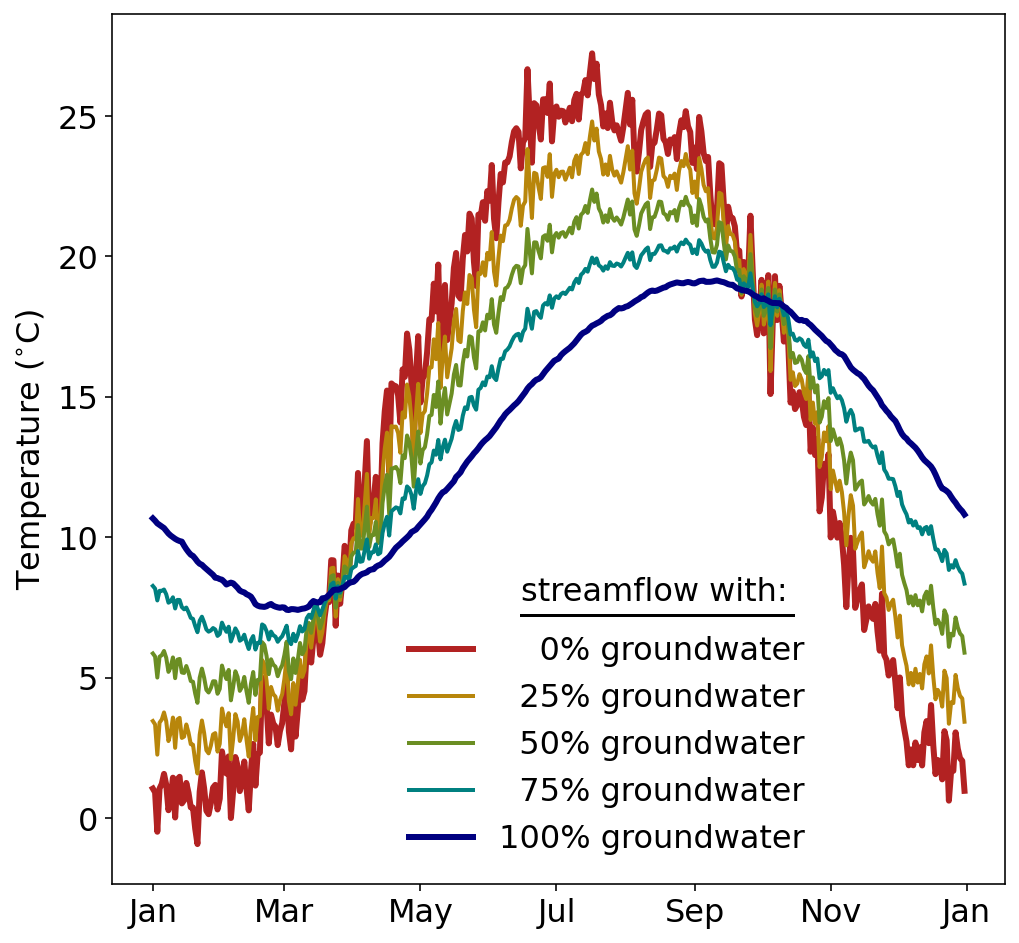

In [167]:
fig,ax = plt.subplots(1,figsize = (8,8))
flow_data['rolling'] = flow_data.guess_temp.rolling(90).mean()*0.5+np.nanmean(flow_data.guess_temp/2)
flow_data1 = flow_data.set_index('date').sort_index()

sw = flow_data1['guess_temp'].resample('D').median()
gw = flow_data1['rolling'].resample('D').median()
ax.plot(sw,label='    0% groundwater',#c=basecolor,
       lw=3,c='firebrick')


colors = ['darkgoldenrod','olivedrab','teal']
i=0
for p in [25,50,75]:
    ax.plot(p*gw/100+(100-p)*sw/100,lw=2,label='  '+str(p)+'% groundwater',
           c=colors[i])
    i+=1

ax.plot(gw,label='100% groundwater',lw=3,c='navy')

plt.legend(loc='lower left',frameon=False,bbox_to_anchor = (0.3,0))

date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)
ax.text(pd.to_datetime('6-15-1999'),7.75,'streamflow with:')
ax.plot([pd.to_datetime('6-15-1999'),
        pd.to_datetime('10-15-1999')],[7.25,7.25],
       c='k')
ax.set_ylabel('Temperature ($^{\circ}$C)',fontsize = fs)